# Random Forest

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, recall_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import scikitplot as skplt

### Separando conjuntos 

In [2]:
df_train = pd.read_csv("dataset_tratado/train_df.csv")
df_val = pd.read_csv("dataset_tratado/validation_df.csv")
df_test = pd.read_csv("dataset_tratado/test_df.csv")

In [3]:
df_train.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.307692,0.052302,0.8,1.0,1.0,0.6,0.4,1.0,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.564103,0.511712,0.4,0.4,0.4,0.4,0.6,0.8,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.551282,0.073506,0.4,0.4,0.4,0.4,0.8,0.4,0.6,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.256410,0.270800,0.8,0.8,0.8,0.6,0.4,0.8,0.4,0.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.294872,0.188611,1.0,0.2,0.2,0.2,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
X_train = df_train.drop('satisfied', axis=1)
y_train = df_train['satisfied'].astype(int)

X_val = df_val.drop('satisfied', axis=1)
y_val = df_val['satisfied'].astype(int)

X_test = df_test.drop('satisfied', axis=1)
y_test = df_test['satisfied'].astype(int)

#### Funções auxiliares

In [28]:
from sklearn.metrics import average_precision_score, roc_auc_score

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def plot_matrix(cm: np.ndarray):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1%', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def compute_performance_metrics(y_test, y_pred_class, y_pred_scores=None):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Calculate precision, recall, and f1-score
    recall = recall_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y_test, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y_test, y_pred_scores)
        aupr = average_precision_score(y_test, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

### Treinando a Random Forest

In [6]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

## Predições no Conjunto de Validação

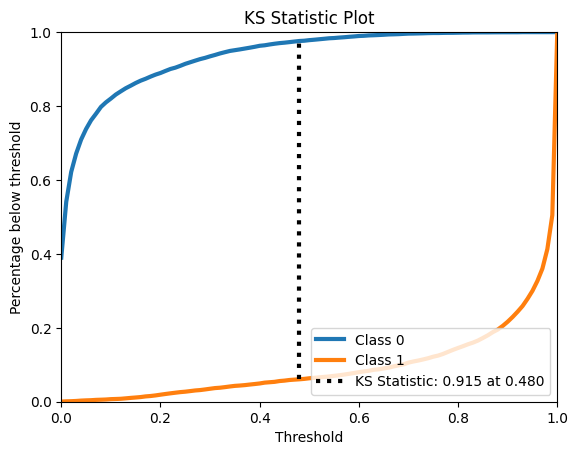


Accuracy:         0.9603
Recall:           0.9366
Precision:        0.9703
F1:               0.9531
AUROC:            0.9930
AUPR:             0.9919


In [32]:
rf_pred_class = rf.predict(X_val)
rf_pred_scores = rf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Ajuste de Hiperparâmetros

### Randomized Search

In [9]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

### Validação Cruzada

In [19]:
rf_best = random_search.best_estimator_

# Avaliando o modelo com validação cruzada
cross_val_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())

Cross-validation scores: [0.96124727 0.96278712 0.96336456 0.96130895 0.96272056]
Mean cross-validation score: 0.9622856926666952


### Reavaliação no conjunto de validação

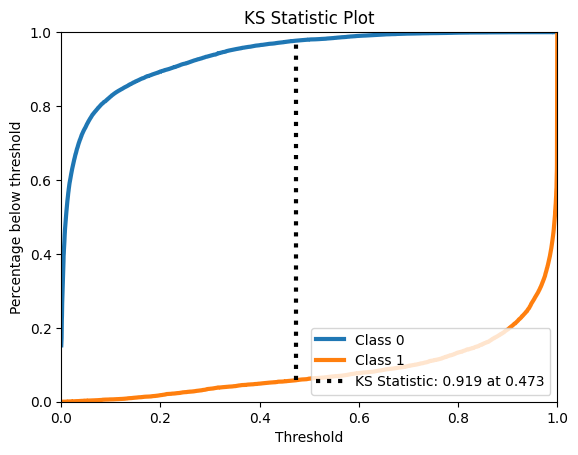

In [21]:
y_val_pred = rf_best.predict(X_val)
y_val_pred_scores = rf_best.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_val_pred, y_val_pred_scores)

In [22]:
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9617
Recall:           0.9376
Precision:        0.9725
F1:               0.9547
AUROC:            0.9938
AUPR:             0.9928


#### Matriz de confusão no conjunto de validação

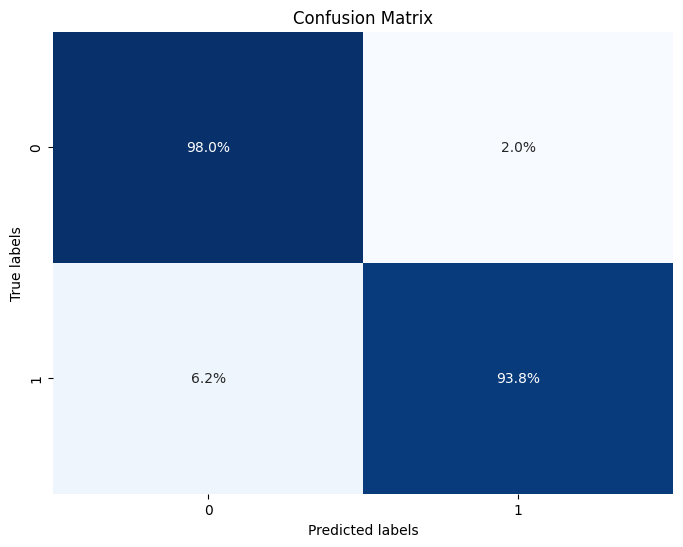

In [34]:
cm = confusion_matrix(y_val, y_val_pred)
plot_matrix(cm)

## Predições no Conjunto de Teste

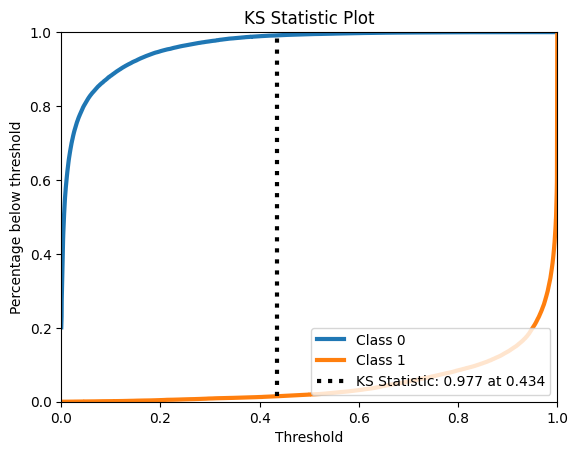

In [23]:
y_test_pred = rf_best.predict(X_test)
y_test_pred_scores = rf_best.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_test_pred, y_test_pred_scores)

In [24]:
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)


Accuracy:         0.9886
Recall:           0.9807
Precision:        0.9929
F1:               0.9868
AUROC:            0.9991
AUPR:             0.9989


### Matriz de confusão

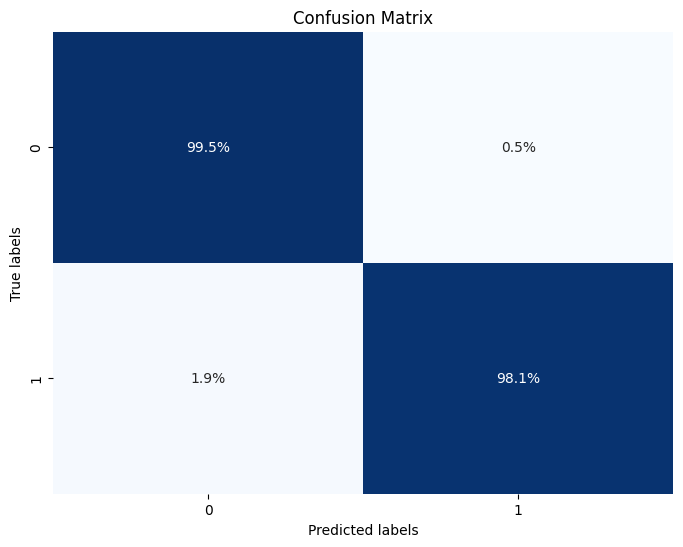

In [26]:
cm = confusion_matrix(y_test, y_test_pred)
plot_matrix(cm)